In [5]:
""""In this file we follow the time series analysis and code from
https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788
and replace their datasets with CPI and inflation data.

"""
#Standard imports

import datetime as dt 
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

#Imports for TSA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA

In [6]:
"""The requests code used by OP did not work for me, probably because I don't have API access
to that website he used. so I will use my data from FRED

# CPI https://fred.stlouisfed.org/series/CPIAUCSL
# Inflation: calculated as pct_change() of CPI"""

#So we first want to import our data
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2021, 9, 30)

#CPI
cpi = pdr.DataReader('CPIAUCSL', 'fred', start = start, end = end)

In [7]:
#Calculate inflation
#Resample for later when we need to model and plot properly
#resample('M') gives us the month end format

inflation = cpi.pct_change().dropna()
inflation = inflation.resample('M').sum()

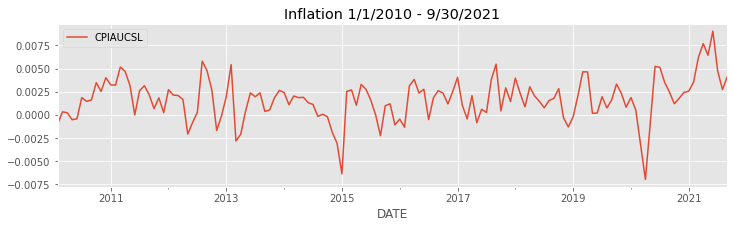

In [8]:
#Then we train test split the data and plot it
train = inflation.iloc[:-10, :]
test = inflation.iloc[-10:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
inflation.plot(figsize = (12,3));
plt.title('Inflation 1/1/2010 - 9/30/2021');

In [9]:
#Here is a good step - normalize the data by doing data - rolling average / rolling std dev 
#Then we do a difference
inflation['z_infl'] = (inflation['CPIAUCSL'] - inflation.CPIAUCSL.rolling(window=12).mean()) / inflation.CPIAUCSL.rolling(window=12).std()
inflation['zp_infl'] = inflation['z_infl'] - inflation['z_infl'].shift(12)

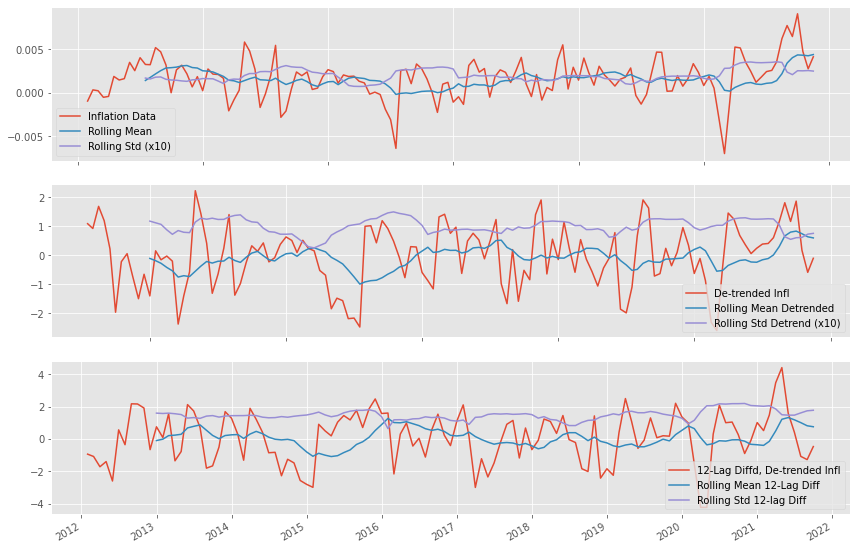

In [10]:
#Okay so now OP defines a function to plot some different time series properties
#We're going to make some figures on some sets of axes with different calculations on them
#Let's get into it!


def plot_rolling(df):
    fig, ax = plt.subplots(3, figsize = (12,9))
    
    ax[0].plot(df.index, df.CPIAUCSL, label = 'Inflation Data')
    ax[0].plot(df.CPIAUCSL.rolling(window = 12).mean(), label = 'Rolling Mean')
    ax[0].plot(df.CPIAUCSL.rolling(window = 12).std(), label = 'Rolling Std (x10)')
    ax[0].legend()
    
    ax[1].plot(df.index, df.z_infl, label = 'De-trended Infl')
    ax[1].plot(df.z_infl.rolling(window = 12).mean(), label = 'Rolling Mean Detrended')
    ax[1].plot(df.z_infl.rolling(window = 12).std(), label = 'Rolling Std Detrend (x10)')
    ax[1].legend()
    
    ax[2].plot(df.index, df.zp_infl, label = '12-Lag Diffd, De-trended Infl')
    ax[2].plot(df.zp_infl.rolling(window = 12).mean(), label = 'Rolling Mean 12-Lag Diff')
    ax[2].plot(df.zp_infl.rolling(window = 12).std(), label = 'Rolling Std 12-lag Diff')
    ax[2].legend()
    
    plt.tight_layout()
    fig.autofmt_xdate()
    
plot_rolling(inflation)

In [11]:
# In this section we will do the Augmented Dickey-Fuller test which helps
# determine whether the series is stationary or not.
# Remember, stationarity is absolutely critical in going further or doing more work.
#I will wrap this code into a function at a later date and then call it 3 times for efficiency

"""Augmented Dickey Fuller:
    H_0: Gamma = 0 (A unit root exists in the data)
    H_A: Gamma < 0 (A unit root does not exist in the data)
    
    If a unit root exists in the data, the series is NOT stationary.
    The more negative the test statistic, the stronger the rejection of the null.
    If the p-value for the test statistic is below a given level of confidence,
    then at that level of confidence, we can reject the null hypothesis.
    We can then conclude that the series does not exist in the data, the data is stationary 
    (most likely).
"""

#1. Straight inflation data
print("Is the inflation data stationary?")

dftest = adfuller(inflation.CPIAUCSL, autolag = 'AIC')
print('Test statistic = {:.3f}'.format(dftest[0]))
print('p-value = {:.3f}'.format(dftest[1]))
print('Critical values: ')
for k,v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% conf.'.\
          format(k, v, 'not' if v < dftest[0] else "", 100 -int(k[:-1])))

print("Is the de-trended data, z_infl, stationary?")

dftest = adfuller(inflation.z_infl.dropna(), autolag = 'AIC')
print('Test statistic = {:.3f}'.format(dftest[0]))
print('p-value = {:.3f}'.format(dftest[1]))
print('Critical values: ')
for k,v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% conf.'.\
          format(k, v, 'not' if v < dftest[0] else "", 100 -int(k[:-1])))
        
print('Is the 12-Lag Diffd, de-trended zp_infl data stationary?')
        
dftest = adfuller(inflation.zp_infl.dropna(), autolag = 'AIC')
print('Test statistic = {:.3f}'.format(dftest[0]))
print('p-value = {:.3f}'.format(dftest[1]))
print('Critical values: ')
for k,v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% conf.'.\
          format(k, v, 'not' if v < dftest[0] else "", 100 -int(k[:-1])))


Is the inflation data stationary?
Test statistic = -6.697
p-value = 0.000
Critical values: 
	1%: -3.47864788917503 - The data is  stationary with 99% conf.
	5%: -2.882721765644168 - The data is  stationary with 95% conf.
	10%: -2.578065326612056 - The data is  stationary with 90% conf.
Is the de-trended data, z_infl, stationary?
Test statistic = -6.909
p-value = 0.000
Critical values: 
	1%: -3.482920063655088 - The data is  stationary with 99% conf.
	5%: -2.884580323367261 - The data is  stationary with 95% conf.
	10%: -2.5790575441750883 - The data is  stationary with 90% conf.
Is the 12-Lag Diffd, de-trended zp_infl data stationary?
Test statistic = -3.682
p-value = 0.004
Critical values: 
	1%: -3.4948504603223145 - The data is  stationary with 99% conf.
	5%: -2.889758398668639 - The data is  stationary with 95% conf.
	10%: -2.5818220155325444 - The data is  stationary with 90% conf.


In [12]:

"""The article mentions KPSS test but d oes not implement it.
I found the tutorial on statsmodels and I will use a function
that is written there for my KPSS test. Just a reminder, I will go back at a later date
and use the ADF test function that is included in the same location.

What is the statement of the KPSS?

H_0: The series is trend-stationary
H_A: The series has a unit root, the series is not stationary.

This is different than the ADF test in the hypotheses, and the outcomes.
Here, if the p-value is less than our confidence interval, we reject the null
that the series IS trend-stationary. This means we believe the alternative, 
that the series is not stationary.
That's opposite of the ADF test whose null is the series is not stationary.

The tests also are not interchangeable, here's a breakdown from statsmodels


Case 1: Both tests conclude that the series is not stationary - The series is not stationary
Case 2: Both tests conclude that the series is stationary - The series is stationary
Case 3: KPSS indicates stationarity and ADF indicates non-stationarity-
    The series is trend stationary. Trend needs to be removed to make series strict stationary. 
    The detrended series is checked for stationarity.
Case 4: KPSS indicates non-stationarity and ADF indicates stationarity-
    The series is difference stationary. Differencing is to be used to make series stationary. 
    The differenced series is checked for stationarity.
"""


#Statsmodels KPSS test function, note this wraps around the kpss function to give nice output
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

#Run it over inflation data
kpss_test(inflation.CPIAUCSL)

#The results show a p-value of 0.10
#This means that at our levels of confidence, we DO NOT REJECT the null hypothesis
#And we conclude that series IS trend-stationary.

Results of KPSS Test:
Test Statistic           0.285517
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


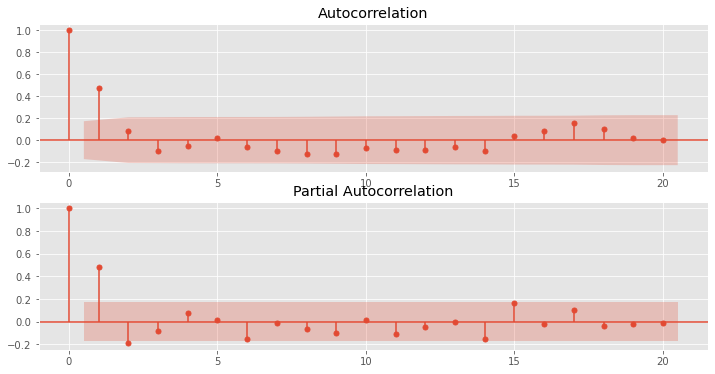

In [13]:
#Time for ACF and PACF

# Autocorrelation measures the autcorr of the series with its own lags
# Partial AC shows the amount of correlation that is not explained by
# correlations at all lower-order lags
# We do this via a plot first

fig, ax = plt.subplots(2, figsize = (12,6))
ax[0] = plot_acf(inflation.z_infl.dropna(), ax = ax[0], lags = 20)
ax[1] = plot_pacf(inflation.z_infl.dropna(), ax = ax[1], lags = 20)


#Looking at the ACF, the correlations drop off right after 1 lag never reaching outside the region
#At the PACF, we get a neg corr at lags 1, 6, 14, and a pos corr at 15
#Note though that lags 6,14,15 barely break out


In [14]:
"""Choosing a model

Exponential smoothing methods are great for non-stationary data (exhibiting trend or seasonal parttern)
    These arise as different kinds of weighted averages
ARIMA methods should be used only for stationary data.
    Remove the trend by deflating or logging, then look at the differenced data.
"""

#When to use Simple Exponential Smoothing?
# Few data points, irregular data, no seasonality or trend

#Holt's Linear Exp Smoothing
# Use when the data has trend but no seasonality

# ************NOTE*****************
# WE HAVE TO REDEFINE TRAIN TEST SPLIT BECAUSE OF HOW THE ARTICLE FLOWS

#Simple Exp Smooth: Basic train/test/split
# Then fit pred

#Due to an error in the model fit predict code, this fix has been implemented alll the way up
#inflation = inflation.resample('M').sum()

#Suggested from an online source
#Here was the error:
"""C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
Traceback (most recent call last):

  File "<ipython-input-68-74c1344b2e5a>", line 5, in <module>
    pred1 = fit1.forecast(9)

  File "C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\base\wrapper.py", line 113, in wrapper
    obj = data.wrap_output(func(results, *args, **kwargs), how)

  File "C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\holtwinters\results.py", line 290, in forecast
    start = self.model._index[-1] + freq

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'NoneType"""


'C:\\Anaconda3\\envs\x0cin_py\\lib\\site-packages\\statsmodels\tsa\\holtwinters\\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation\n  warnings.warn(\nTraceback (most recent call last):\n\n  File "<ipython-input-68-74c1344b2e5a>", line 5, in <module>\n    pred1 = fit1.forecast(9)\n\n  File "C:\\Anaconda3\\envs\x0cin_py\\lib\\site-packages\\statsmodels\x08ase\\wrapper.py", line 113, in wrapper\n    obj = data.wrap_output(func(results, *args, **kwargs), how)\n\n  File "C:\\Anaconda3\\envs\x0cin_py\\lib\\site-packages\\statsmodels\tsa\\holtwinters\results.py", line 290, in forecast\n    start = self.model._index[-1] + freq\n\nTypeError: unsupported operand type(s) for +: \'Timestamp\' and \'NoneType'

In [15]:
# ************NOTE*****************
# WE HAVE TO REDEFINE TRAIN TEST SPLIT BECAUSE OF HOW THE ARTICLE FLOWS

#make a new df, drop the columns no longer in use, Train Test split
infl_new = inflation.drop(['z_infl', 'zp_infl'], axis = 1)

train = infl_new.iloc[:130, :]
test = infl_new.iloc[-10:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()

In [16]:
#Create and fit a Simple Exponential Smoothing (SES) model
ses_model = SimpleExpSmoothing(np.asarray(train['CPIAUCSL']))
ses_model._index = pd.to_datetime(train.index)

fit1 = ses_model.fit()
pred1 = fit1.forecast(10)
fit2 = ses_model.fit(smoothing_level = .2)
pred2 = fit2.forecast(10)
fit3 = ses_model.fit(smoothing_level = .5)
pred3 = fit3.forecast(10)

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


(130, 1)
(130,)
(0,)
(0, 1)
(130,)
(0,)
(10,)


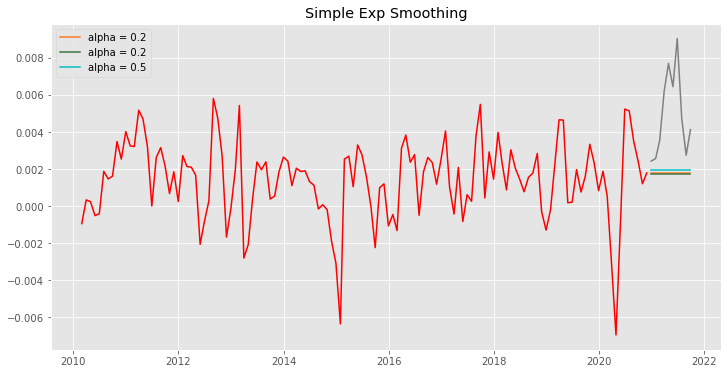

In [22]:
#Plot
#added the line ax.plot(infl_new[:130], color = 'red') so that the previous data shows
#in addition to the actual + predicted data
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(infl_new[:130], color = 'red')
ax.plot(train.index[130:], train.values[130:])
ax.plot(test.index, test.values, color = 'gray')
for p, f, c in zip((pred1, pred2, pred3), (fit1, fit2, fit3), ('#ff7823','#3c763d','c')):
    ax.plot(train.index[130:], f.fittedvalues[130:], color = c)
    ax.plot(test.index, p, label = 'alpha = ' + str(f.params['smoothing_level'])[:3], color = c)
plt.title('Simple Exp Smoothing')
plt.legend();

In [17]:
#Now let's kick it up a notch!
#Holt Model: 
holt_model = Holt(np.asarray(train['CPIAUCSL']))
holt_model._index = pd.to_datetime(train.index)

fit1 = holt_model.fit(smoothing_level = 0.3, smoothing_trend = 0.05)
pred1 = fit1.forecast(10)
fit2 = holt_model.fit(optimized = True)
pred2 = fit2.forecast(10)
fit3 = holt_model.fit(smoothing_level = 0.3, smoothing_trend = 0.2)
pred3 = fit3.forecast(10)

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


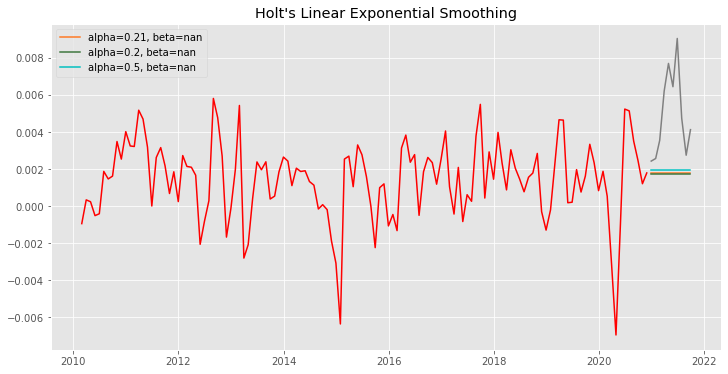

In [21]:
#Plot
#added the line ax.plot(infl_new[:130], color = 'red') so that the previous data shows
#in addition to the actual + predicted data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(infl_new[:130], color = 'red')
ax.plot(train.index[130:], train.values[130:])
ax.plot(test.index, test.values, color = 'gray')
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[130:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4], color=c)
plt.title("Holt's Linear Exponential Smoothing")
plt.legend();


In [19]:
#Next up, Holt's Dampened Trend

#The main issue with Holt's linear here is that it predicts a line, no other changes...
#so, Holt made a dampened trend model which addresses the issue

"""Data has a trend. Use the multiplicative version, unless 
the data has been logged before. In this case, use the additive version.

A damping parameter is introduced as well.

We will now use ExponentialSmoothing from the holtwinters part of statsmodels.tsa"""

"""So our data has negative values and the multiplicative model only accepts values >0
no zeroes, no negatives. 

****NOTE**** I was getting a unicode error because of util\ _decorators.py 
So I removed a ton of aslhes in the file paths.*****)

Here is the error:
    Traceback (most recent call last):

  File <ipython-input-199-d34d4e1a27d1>, line 1, in <module>
    model = ExponentialSmoothing(np.asarray(train['CPIAUCSL']), trend = 'mul', seasonal = None)

  File C:\Anaconda3\envs\fin_py\lib\site-packages\pandas util _decorators.py, line 207, in wrapper
    return func(*args, **kwargs)

  File C:Anaconda3 envs fin_py lib site-packages statsmodels tsa holtwinters model.py, line 242, in __init__
    raise ValueError(

ValueError: endog must be strictly positive when usingmultiplicative trend or seasonal components.

A google search turned up an idea to raise the values by a number so they are not 0 or negative
and then to subtract it from the forecast.

I am not sure this is correct, but I have implemented it.
I will add 0.01 The largest negative value is around -0.007, so I think my number is...okay"""

"So our data has negative values and the multiplicative model only accepts values >0\nno zeroes, no negatives. \n\n****NOTE**** I was getting a unicode error because of util\\ _decorators.py \nSo I removed a ton of aslhes in the file paths.*****)\n\nHere is the error:\n    Traceback (most recent call last):\n\n  File <ipython-input-199-d34d4e1a27d1>, line 1, in <module>\n    model = ExponentialSmoothing(np.asarray(train['CPIAUCSL']), trend = 'mul', seasonal = None)\n\n  File C:\\Anaconda3\\envs\x0cin_py\\lib\\site-packages\\pandas util _decorators.py, line 207, in wrapper\n    return func(*args, **kwargs)\n\n  File C:Anaconda3 envs fin_py lib site-packages statsmodels tsa holtwinters model.py, line 242, in __init__\n    raise ValueError(\n\nValueError: endog must be strictly positive when usingmultiplicative trend or seasonal components.\n\nA google search turned up an idea to raise the values by a number so they are not 0 or negative\nand then to subtract it from the forecast.\n\nI am

In [21]:
#Model 1 no dampening
model = ExponentialSmoothing(np.asarray(train['CPIAUCSL'] + 0.01), trend = 'mul', seasonal = None)
#model2 the dampening --- damped = True
model2 = ExponentialSmoothing(np.asarray(train['CPIAUCSL'] + 0.01), trend = 'mul', seasonal = None, damped_trend = True)
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
fit2 = model2.fit()
pred1 = fit1.forecast(10) - 0.01 
pred2 = fit2.forecast(10) - 0.01

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


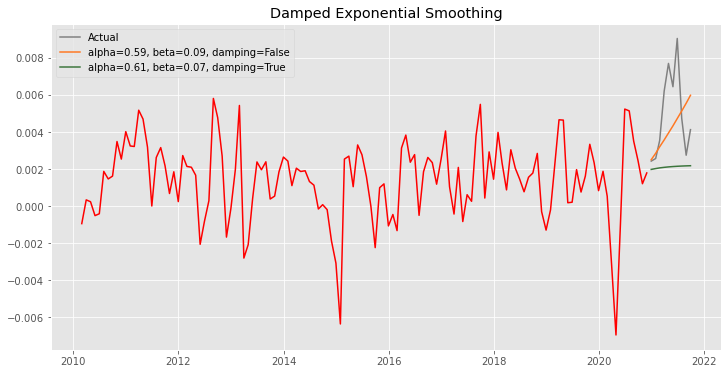

In [22]:
#Time to plot

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(infl_new[:130], color = 'red')

ax.plot(train.index[130:], train.values[130:])
ax.plot(test.index, test.values, color = 'gray', label = 'Actual')

for f, p, c in zip((fit1, fit2), (pred1, pred2), ('#ff7823','#3c763d')):
    ax.plot(train.index[130:], f.fittedvalues[130:], color = c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
ax.set_title("Damped Exponential Smoothing");
plt.legend();


In [23]:

"""In order to proceed forward into the ARIMA section of the article,
we need to add a small value to the data so the data is strictly positive.
This is for applications of logarithms and multiplicative models.

Let's do that now."""

"""Let's talk briefly about ARIMA models.

AutoRegressive Integrated Moving Average.

This is for stationary series. So we have to verify or perform necessary operations
prior to modelling.

The model has three components
1) A weighted sum of lagged values of the series - Autoregressive ( p )
2) A difference of the time series - Integrated ( d )
3) A weighted sum of lagged forecasted errors - Moving Average ( q )

The model is specified as ARIMA(p, d, q) - respectively"""

#Shift the data to pos
infl_pos = infl_new + 0.01

Text(0.5, 1.0, 'Logged Inflation Data (deflated)')

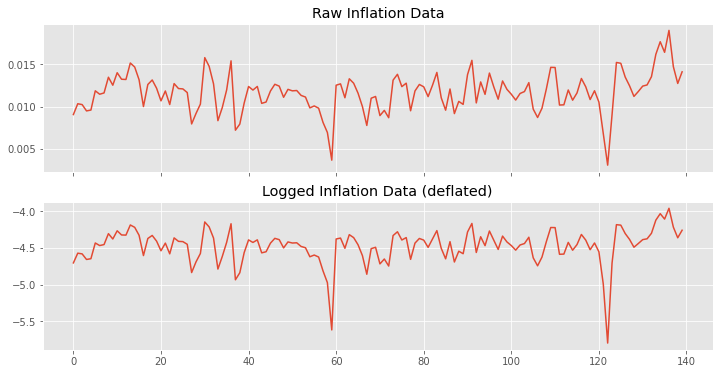

In [24]:
#Plot before moving forward

fig, ax = plt.subplots(2, sharex = True, figsize = (12, 6))
ax[0].plot(infl_pos.CPIAUCSL.values)
ax[0].set_title('Raw Inflation Data')
ax[1].plot(np.log(infl_pos.CPIAUCSL.values))
ax[1].set_title('Logged Inflation Data (deflated)')

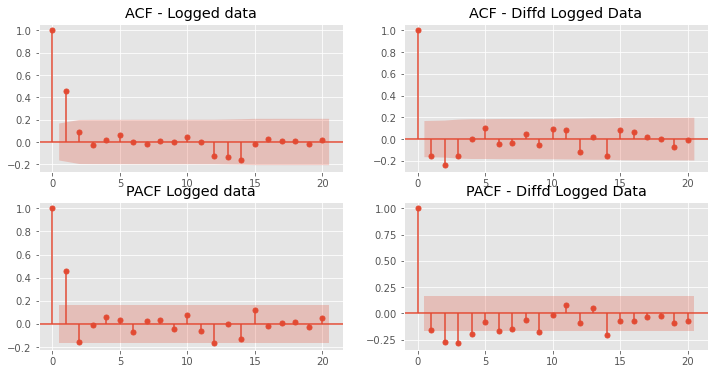

In [25]:
#Plotting the ACF + PACF of the logged data and the diffd logged data

fig, ax = plt.subplots(2, 2, figsize = (12,6))
first_diff = (np.log(infl_pos.CPIAUCSL) - np.log(infl_pos.CPIAUCSL).shift()).dropna()
ax[0, 0] = plot_acf(np.log(infl_pos.CPIAUCSL), ax = ax[0,0], lags = 20, title = 'ACF - Logged data')
ax[1, 0] = plot_pacf(np.log(infl_pos.CPIAUCSL), ax = ax[1, 0], lags = 20, title = 'PACF Logged data')
ax[0, 1] = plot_acf(first_diff, ax = ax[0, 1], lags = 20, title = 'ACF - Diffd Logged Data')
ax[1, 1] = plot_pacf(first_diff, ax = ax[1,1], lags = 20, title = 'PACF - Diffd Logged Data')

In [26]:

#Our p/acf plots look good. Maybe the diffd series needs another differencing
#but for now, it's okay

In [27]:
print('Is our data stationary?')
kpsstest = kpss(np.log(infl_pos.CPIAUCSL), 'ct')
print('Test statistic = {:.3f}'.format(kpsstest[0]))
print('P-value = {:.3f}'.format(kpsstest[1]))
print('Critical values : ')
for k, v in kpsstest[3].items():
    print('\t{}: {}'.format(k,v))
    
#Our test statistic is below the p value
# So we do not reject the null hypothesis (Series is trend stationary)
# We reject the alternative that the series is NOT trend stationary.
# Our p-value is atrocious 

Is our data stationary?
Test statistic = 0.103
P-value = 0.100
Critical values : 
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [28]:
#Let me do a quick Augmented Dickey-Fuller test
#Just copied the code from all the way up top

dftest = adfuller(np.log(infl_pos.CPIAUCSL), autolag = 'AIC')
print('Test statistic = {:.3f}'.format(dftest[0]))
print('p-value = {:.3f}'.format(dftest[1]))
print('Critical values: ')
for k,v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% conf.'.\
          format(k, v, 'not' if v < dftest[0] else "", 100 -int(k[:-1])))
        
#So the ADF null hypothesis is: The series has a unit root (it is not stationary)
#And the alternative is that it has no unit root (is stationary)

#Our test stat is -7 which is wayyy below the critical values
#and our p-value is effectively 0
#Therefore, we may reject the null hypothesis, concluding our series is stationary.
#Thank god

Test statistic = -7.034
p-value = 0.000
Critical values: 
	1%: -3.47864788917503 - The data is  stationary with 99% conf.
	5%: -2.882721765644168 - The data is  stationary with 95% conf.
	10%: -2.578065326612056 - The data is  stationary with 90% conf.


                              ARMA Model Results                              
Dep. Variable:               CPIAUCSL   No. Observations:                  140
Model:                     ARMA(0, 0)   Log Likelihood                   4.699
Method:                           css   S.D. of innovations              0.234
Date:                Wed, 05 Jan 2022   AIC                             -5.397
Time:                        22:44:20   BIC                              0.486
Sample:                    02-28-2010   HQIC                            -3.006
                         - 09-30-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4756      0.020   -226.321      0.000      -4.514      -4.437
                             ARIMA Model Results                              
Dep. Variable:             D.CPIAUCSL   No. Observat

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

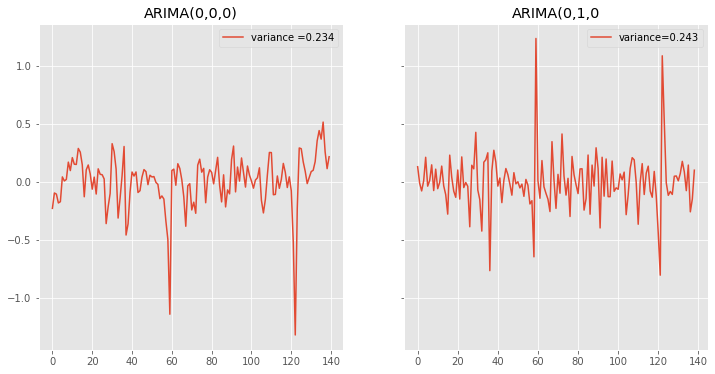

In [29]:
#Time for ARIMA!!!
#model fit predict

# (p,d,q) = 0,0,0
model = ARIMA(np.log(infl_pos.CPIAUCSL).dropna(), (0,0,0))
res_000 = model.fit()
print(res_000.summary())

#(p, d, q) = 0,1,0
model2 = ARIMA(np.log(infl_pos.CPIAUCSL).dropna(), (0,1,0))
res_010 = model2.fit()
print(res_010.summary())

#Plot the new series

fig, ax = plt.subplots(1, 2, sharey = True, figsize = (12,6))
ax[0].plot(res_000.resid.values, label = 'variance ={:.3f}'.format(np.std(res_000.resid.values)))
ax[0].set_title('ARIMA(0,0,0)')
ax[0].legend()

ax[1].plot(res_010.resid.values, label = 'variance={:.3f}'.format(np.std(res_010.resid.values)))
ax[1].set_title('ARIMA(0,1,0')
ax[1].legend()

#The lower the AIC of the model the better it performs.

                              ARMA Model Results                              
Dep. Variable:               CPIAUCSL   No. Observations:                  140
Model:                     ARMA(1, 1)   Log Likelihood                  22.744
Method:                       css-mle   S.D. of innovations              0.205
Date:                Wed, 05 Jan 2022   AIC                            -37.487
Time:                        22:46:48   BIC                            -25.721
Sample:                    02-28-2010   HQIC                           -32.706
                         - 09-30-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.4756      0.030   -151.506      0.000      -4.534      -4.418
ar.L1.CPIAUCSL     0.2569      0.153      1.681      0.093      -0.043       0.556
ma.L1.CPIAUCSL     0.2691      0.148

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


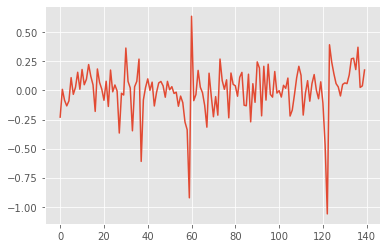

In [30]:
#I want to use the below code to play around with the parameters.
#Time for work. God damn.

modelpdq = ARIMA(np.log(infl_pos.CPIAUCSL).dropna(),(1,0,1))
res_pdq = modelpdq.fit()
print(res_pdq.summary())
plt.plot(res_pdq.resid.values)

#From the above code, the model 1,0,1 gives the best results (a lot comes from the MA(q) term)

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be remove

'This concludes the analysis. \nGiven how inflation actually turned out, this model performs quite poorly.\nI may repeat this analysis using CPI only and not the inflation itself.\nThat might be interesting.\nFor now...au revoir'

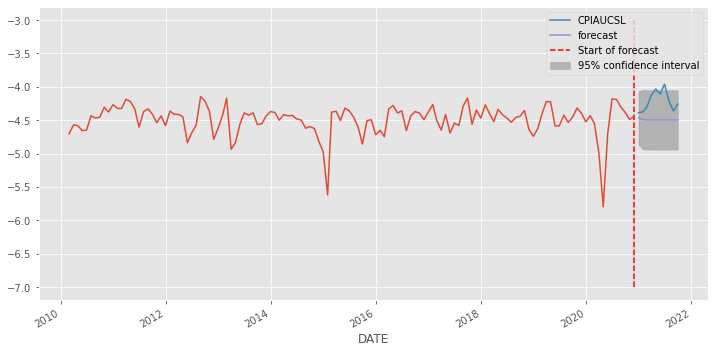

In [31]:
model = ARIMA(np.log(infl_pos.CPIAUCSL).dropna()[:-10],(1,0,1))
res_101 = model.fit()

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(np.log(infl_pos.CPIAUCSL.dropna()[:130]))
infl_pos.index = pd.to_datetime(infl_pos.index, format="%Y-%m")
np.log(infl_pos.CPIAUCSL).dropna()[130:].plot(ax=ax)
ax.vlines('2020-12', ymin = -7, ymax = -3, linestyle='--', color='r', label='Start of forecast');

# - NOTE from the official matplotlib documentation :
# -- The dynamic keyword affects in-sample prediction. 
# -- If dynamic is False, then the in-sample lagged values are used for prediction. 
# -- If dynamic is True, then in-sample forecasts are used in place of lagged dependent variables.

ax = res_101.plot_predict('2020-12', '2021-09', dynamic = True, plot_insample = False, ax = ax)

#Looking at this plot, the forecast is horrible LMAO


"""This concludes the analysis. 
Given how inflation actually turned out, this model performs quite poorly.
I may repeat this analysis using CPI only and not the inflation itself.
That might be interesting.
For now...au revoir"""

NameError: name 'ARIMA' is not defined